## Analytical Section for 03_train_models.ipynb

### 1. Feature Importance Analysis

Processed data loaded successfully!
Dataset Shape: (20631, 42)

First few rows:
   unit_id  time_cycles  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0        1            1      0.459770      0.166667           0.0       0.0   
1        1            2      0.609195      0.250000           0.0       0.0   
2        1            3      0.252874      0.750000           0.0       0.0   
3        1            4      0.540230      0.500000           0.0       0.0   
4        1            5      0.390805      0.333333           0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_7_CumSum  \
0  0.183735  0.406802  0.309757       0.0  ...         0.000010   
1  0.283133  0.453019  0.352633       0.0  ...         0.002782   
2  0.343373  0.369523  0.370527       0.0  ...         0.005557   
3  0.343373  0.256159  0.331195       0.0  ...         0.008333   
4  0.349398  0.257467  0.404625       0.0  ...         0.011106   

   sensor_11_MA_5  sensor_11_Rolling_Std  

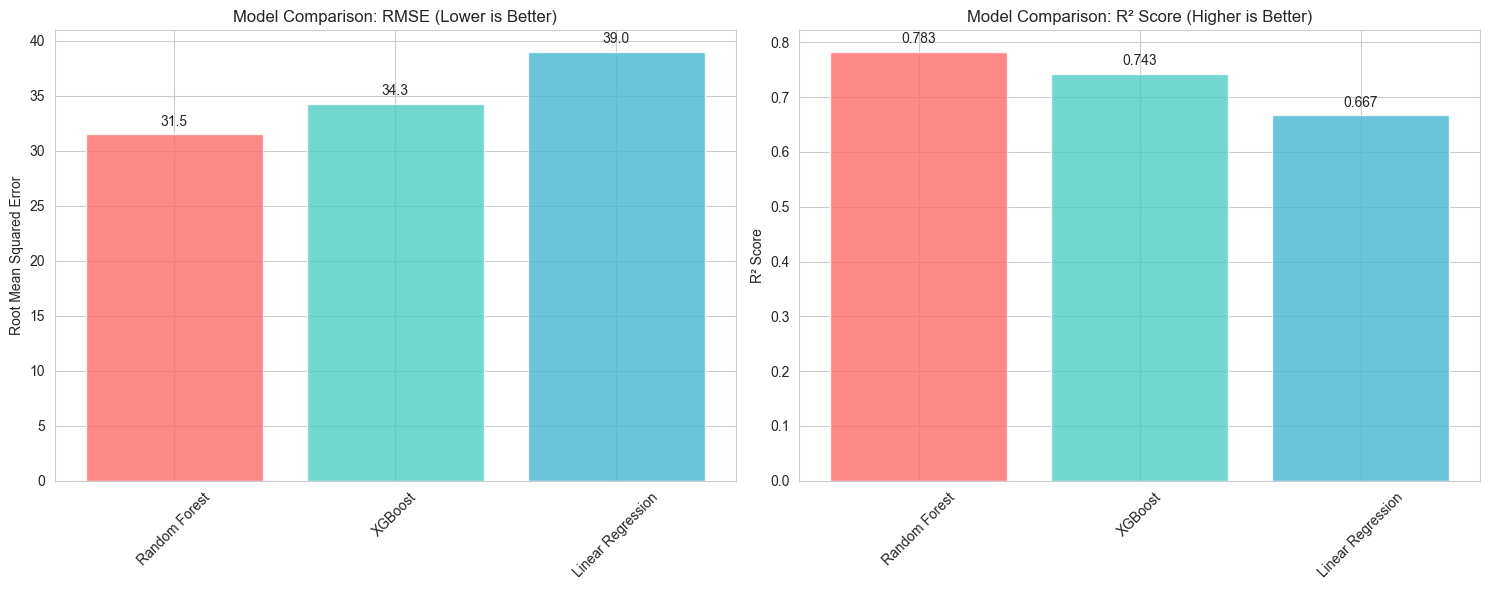

📊 Performance Comparison Table:
                        RMSE        MAE        R2
Random Forest      31.498912  21.950346  0.782835
XGBoost            34.279389  24.243574  0.742804
Linear Regression  38.978638  30.127023  0.667454
🏆 Champion Model: Random Forest


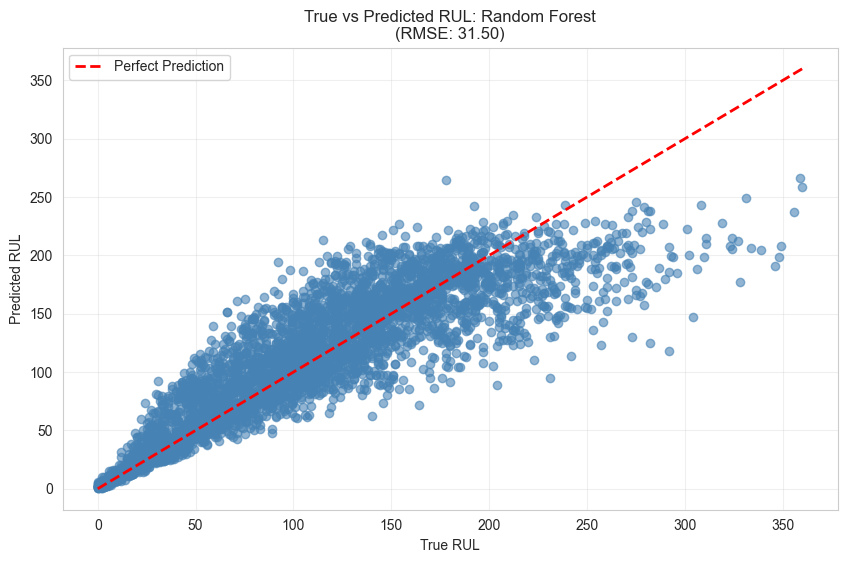


FEATURE IMPORTANCE ANALYSIS

📊 Analyzing Feature Importance for Random Forest:


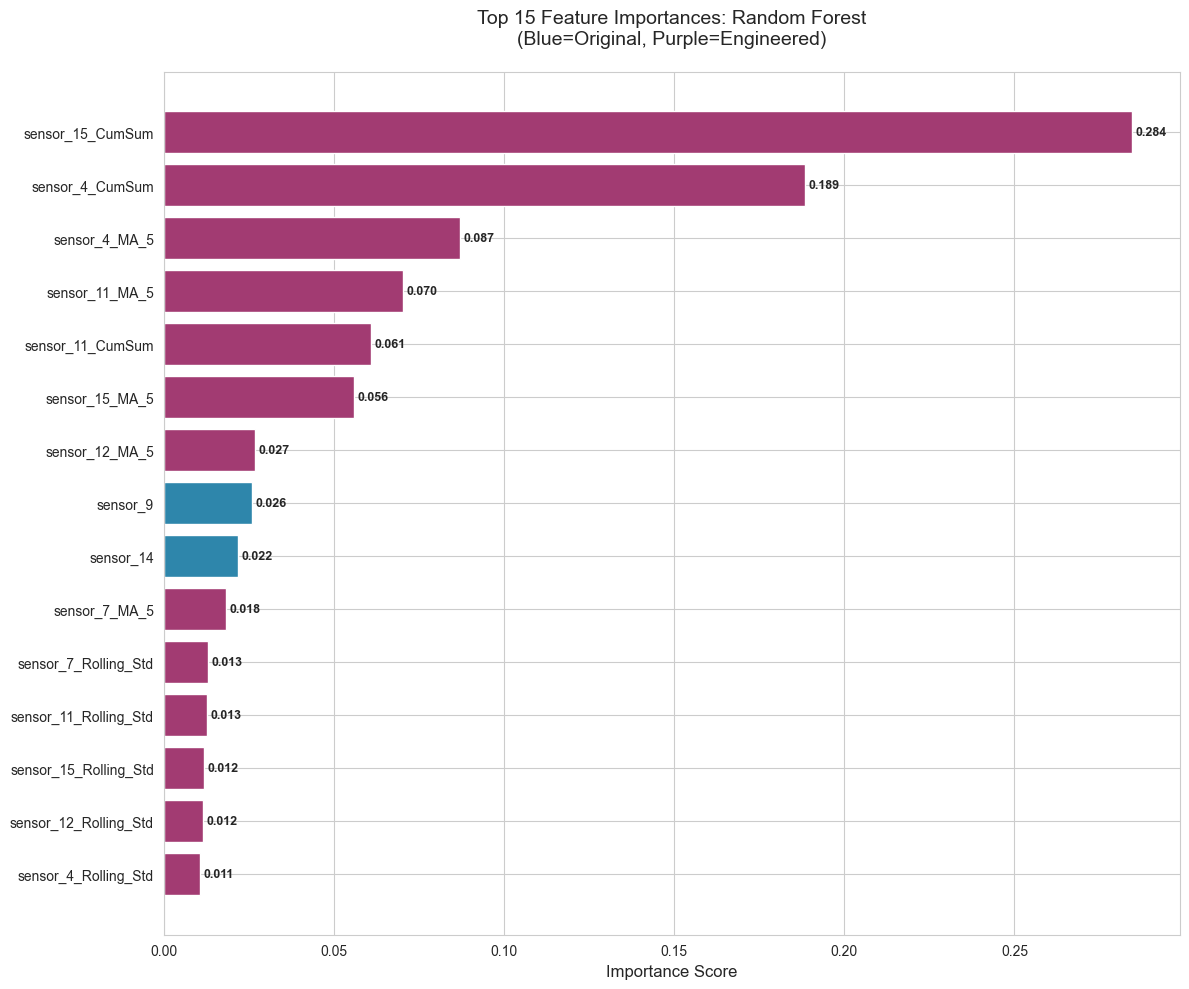

   Top 5 Features: ['sensor_15_CumSum', 'sensor_4_CumSum', 'sensor_4_MA_5', 'sensor_11_MA_5', 'sensor_11_CumSum']
   Engineered features in top 5: 5/5
   Most important feature: 'sensor_15_CumSum' (importance: 0.284)

   🔬 Validation against EDA Findings:
   EDA Top Sensors: ['sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']
   Model Top Sensors: []
   Consistent findings: 0/5 sensors validated

📊 Analyzing Feature Importance for XGBoost:


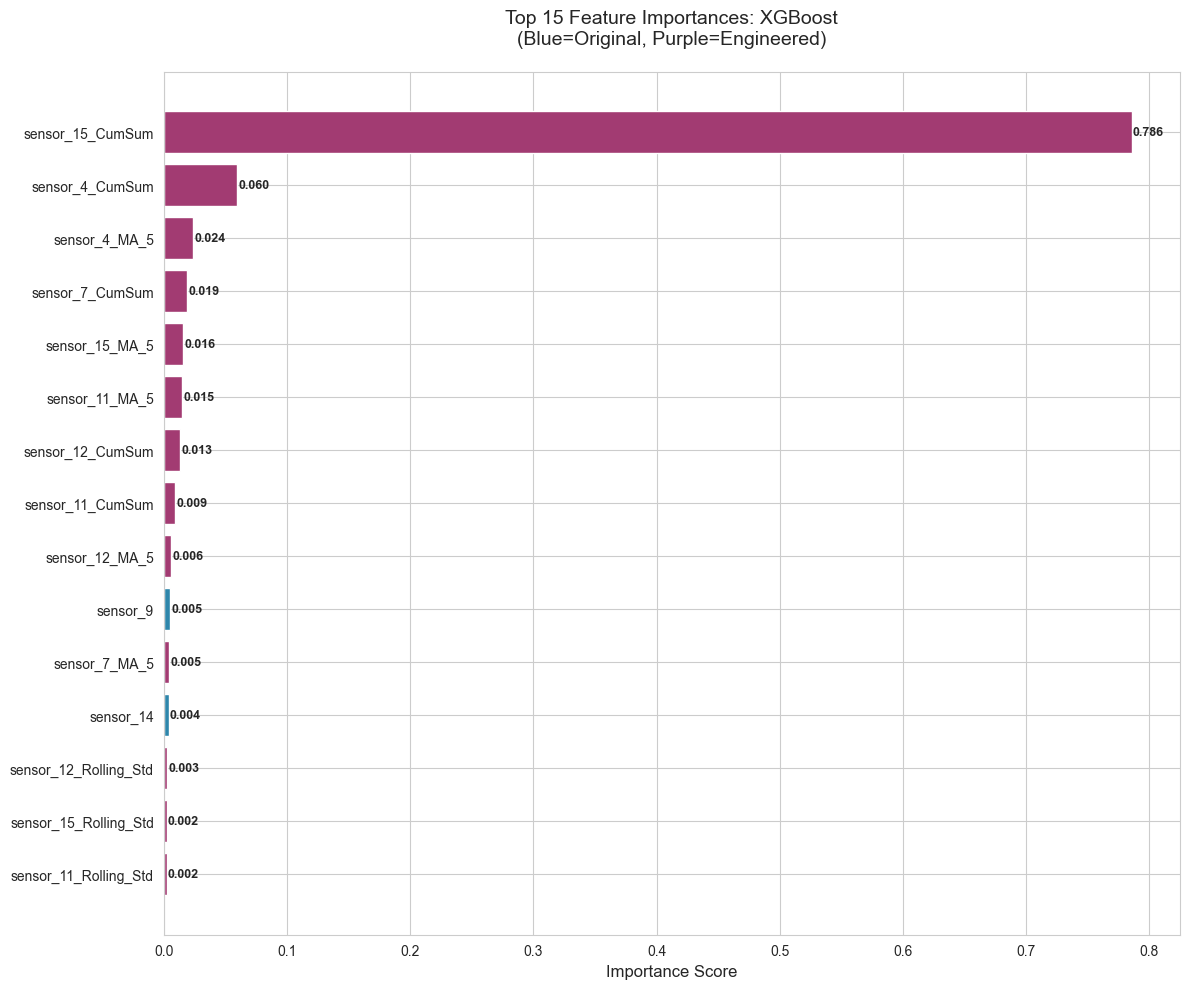

   Top 5 Features: ['sensor_15_CumSum', 'sensor_4_CumSum', 'sensor_4_MA_5', 'sensor_7_CumSum', 'sensor_15_MA_5']
   Engineered features in top 5: 5/5
   Most important feature: 'sensor_15_CumSum' (importance: 0.786)

   🔬 Validation against EDA Findings:
   EDA Top Sensors: ['sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']
   Model Top Sensors: []
   Consistent findings: 0/5 sensors validated

ERROR ANALYSIS


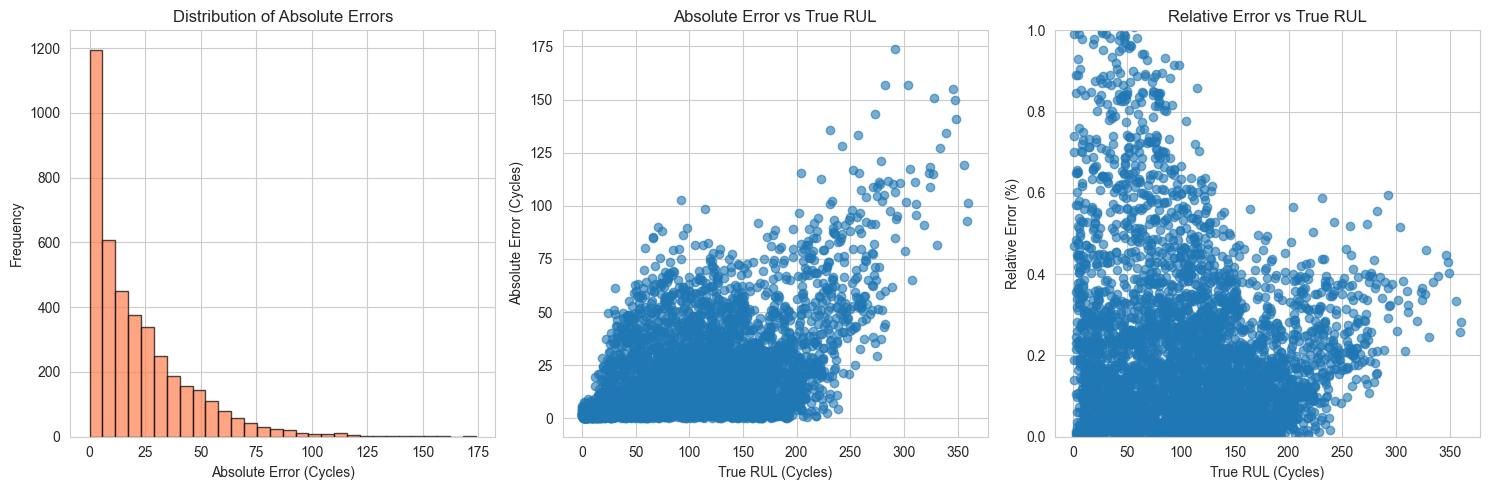

📋 Comprehensive Error Analysis for Random Forest:
   Mean Absolute Error: 21.95 cycles
   Median Absolute Error: 14.52 cycles
   Maximum Error: 173.90 cycles
   Standard Deviation: 22.59 cycles
   Accuracy within 10 cycles: 40.3%
   Accuracy within 20 cycles: 58.9%
   Accuracy within 30 cycles: 73.2%
 Model saved to: ../models/random_forest_baseline.pkl

💾 Best model saved to: ../models/random_forest_baseline.pkl

FEATURE CORRELATION ANALYSIS


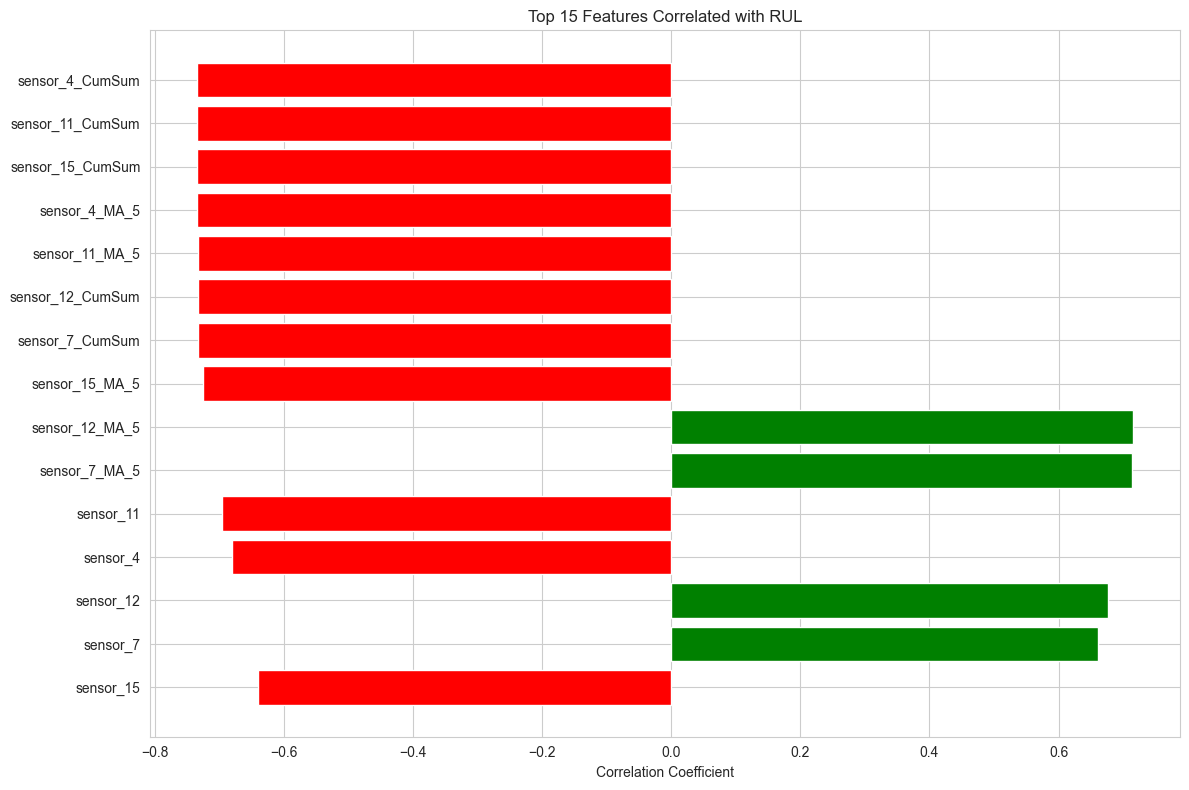

Top 10 features correlated with RUL:
 1. sensor_4_CumSum: -0.735
 2. sensor_11_CumSum: -0.735
 3. sensor_15_CumSum: -0.735
 4. sensor_4_MA_5: -0.735
 5. sensor_11_MA_5: -0.734
 6. sensor_12_CumSum: -0.734
 7. sensor_7_CumSum: -0.734
 8. sensor_15_MA_5: -0.725
 9. sensor_12_MA_5: 0.716
10. sensor_7_MA_5: 0.714


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib

# Add the 'src' directory to the path to import our custom modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# Import our custom training module
from src.models.train_model import *

# Set plotting style
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load the processed data from Phase 3
processed_data_path = '../data/processed/train_FD001_processed.csv'
train_df_processed = pd.read_csv(processed_data_path)

print("Processed data loaded successfully!")
print(f"Dataset Shape: {train_df_processed.shape}")
print("\nFirst few rows:")
print(train_df_processed.head())

# Prepare the data for modeling using our custom function
X_train, X_val, y_train, y_val, feature_columns = prepare_data(train_df_processed)

print(f"\nFeature columns ({len(feature_columns)}):")
print(feature_columns)

# Train all models and evaluate their performance
model_performance = train_all_models(X_train, y_train, X_val, y_val)

# Create a comprehensive performance comparison
performance_df = plot_performance_comparison(model_performance)

print("📊 Performance Comparison Table:")
print(performance_df.sort_values('RMSE'))

# Identify the best model
best_model_name = performance_df.index[0]
best_model = model_performance[best_model_name]['Model']

print(f"🏆 Champion Model: {best_model_name}")

# Get predictions from the best model
best_predictions = best_model.predict(X_val)

# Plot True vs Predicted values
plot_true_vs_predicted(y_val, best_predictions, best_model_name)

# Now analyze feature importance for ALL tree-based models
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

tree_models = {name: data['Model'] for name, data in model_performance.items() 
               if name in ['Random Forest', 'XGBoost']}

if tree_models:
    for model_name, model in tree_models.items():
        print(f"\n📊 Analyzing Feature Importance for {model_name}:")
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance_scores = model.feature_importances_
        else:
            # For XGBoost with get_booster method
            try:
                importance_scores = model.get_booster().get_score(importance_type='weight')
                importance_scores = np.array([importance_scores.get(f, 0) for f in feature_columns])
            except:
                # Fallback for different XGBoost versions
                importance_scores = model.feature_importances_
        
        # Create DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        # Plot top 15 features
        plt.figure(figsize=(12, 10))
        top_features = feature_importance_df.head(15)
        
        # Create color mapping based on whether feature is original or engineered
        colors = ['#2E86AB' if not any(x in feat for x in ['_MA_', '_Rolling_', '_CumSum']) 
                 else '#A23B72' for feat in top_features['feature']]
        
        bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance Score', fontsize=12)
        plt.title(f'Top 15 Feature Importances: {model_name}\n(Blue=Original, Purple=Engineered)', 
                 fontsize=14, pad=20)
        plt.gca().invert_yaxis()  # Most important at top
        
        # Add value labels
        for i, (idx, row) in enumerate(top_features.iterrows()):
            plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
                    va='center', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print key insights
        top_5 = top_features.head(5)['feature'].tolist()
        engineered_in_top = sum(1 for feat in top_5 if any(x in feat for x in ['_MA_', '_Rolling_', '_CumSum']))
        
        print(f"   Top 5 Features: {top_5}")
        print(f"   Engineered features in top 5: {engineered_in_top}/5")
        print(f"   Most important feature: '{top_features.iloc[0]['feature']}' "
              f"(importance: {top_features.iloc[0]['importance']:.3f})")
        
        # Validation against EDA findings
        print("\n   🔬 Validation against EDA Findings:")
        eda_top_sensors = ['sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']
        model_top_sensors = [feat for feat in top_5 if feat.startswith('sensor_') and not any(x in feat for x in ['_MA_', '_Rolling_', '_CumSum'])]
        
        matches = set(eda_top_sensors) & set(model_top_sensors)
        print(f"   EDA Top Sensors: {eda_top_sensors}")
        print(f"   Model Top Sensors: {model_top_sensors}")
        print(f"   Consistent findings: {len(matches)}/{len(eda_top_sensors)} sensors validated")
        
else:
    print("No tree-based models available for feature importance analysis.")

# Enhanced error analysis
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Create a DataFrame for error analysis
error_analysis_df = pd.DataFrame({
    'True_RUL': y_val.values,
    'Predicted_RUL': best_predictions,
    'Absolute_Error': np.abs(y_val.values - best_predictions),
    'Relative_Error': np.abs(y_val.values - best_predictions) / y_val.values
})

# Analyze error distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(error_analysis_df['Absolute_Error'], bins=30, alpha=0.7, color='coral', edgecolor='black')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error (Cycles)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.scatter(error_analysis_df['True_RUL'], error_analysis_df['Absolute_Error'], alpha=0.6)
plt.title('Absolute Error vs True RUL')
plt.xlabel('True RUL (Cycles)')
plt.ylabel('Absolute Error (Cycles)')

plt.subplot(1, 3, 3)
plt.scatter(error_analysis_df['True_RUL'], error_analysis_df['Relative_Error'], alpha=0.6)
plt.title('Relative Error vs True RUL')
plt.xlabel('True RUL (Cycles)')
plt.ylabel('Relative Error (%)')
plt.ylim(0, 1)  # Limit to 100% error

plt.tight_layout()
plt.show()

# Calculate error statistics
mean_error = error_analysis_df['Absolute_Error'].mean()
median_error = error_analysis_df['Absolute_Error'].median()
max_error = error_analysis_df['Absolute_Error'].max()
std_error = error_analysis_df['Absolute_Error'].std()

# Calculate accuracy within different tolerance levels
within_10_cycles = (error_analysis_df['Absolute_Error'] <= 10).mean() * 100
within_20_cycles = (error_analysis_df['Absolute_Error'] <= 20).mean() * 100
within_30_cycles = (error_analysis_df['Absolute_Error'] <= 30).mean() * 100

print(f"📋 Comprehensive Error Analysis for {best_model_name}:")
print(f"   Mean Absolute Error: {mean_error:.2f} cycles")
print(f"   Median Absolute Error: {median_error:.2f} cycles")
print(f"   Maximum Error: {max_error:.2f} cycles")
print(f"   Standard Deviation: {std_error:.2f} cycles")
print(f"   Accuracy within 10 cycles: {within_10_cycles:.1f}%")
print(f"   Accuracy within 20 cycles: {within_20_cycles:.1f}%")
print(f"   Accuracy within 30 cycles: {within_30_cycles:.1f}%")

# Save the best model for future use
best_model_path = f'../models/{best_model_name.lower().replace(" ", "_")}_baseline.pkl'
save_model(best_model, best_model_path)
print(f"\n💾 Best model saved to: {best_model_path}")

# Additional: Feature correlation with target
print("\n" + "="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

# Create a temporary dataframe for correlation analysis
corr_df = X_train.copy()
corr_df['RUL'] = y_train.values

# Calculate correlations
correlations = corr_df.corr()['RUL'].drop('RUL').sort_values(key=abs, ascending=False)

# Plot top correlated features
plt.figure(figsize=(12, 8))
top_corr = correlations.head(15)
colors = ['red' if x < 0 else 'green' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation Coefficient')
plt.title('Top 15 Features Correlated with RUL')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features correlated with RUL:")
for i, (feat, corr) in enumerate(top_corr.head(10).items(), 1):
    print(f"{i:2d}. {feat}: {corr:.3f}")

### 2. Comprehensive Error Analysis


2. ERROR ANALYSIS
----------------------------------------
📋 Overall Error Statistics for Random Forest:
   Mean Absolute Error: 21.95 cycles
   Median Absolute Error: 14.52 cycles
   Std Deviation of Error: 22.59 cycles
   Max Error: 173.90 cycles
   Mean Error Percentage: 24.69%


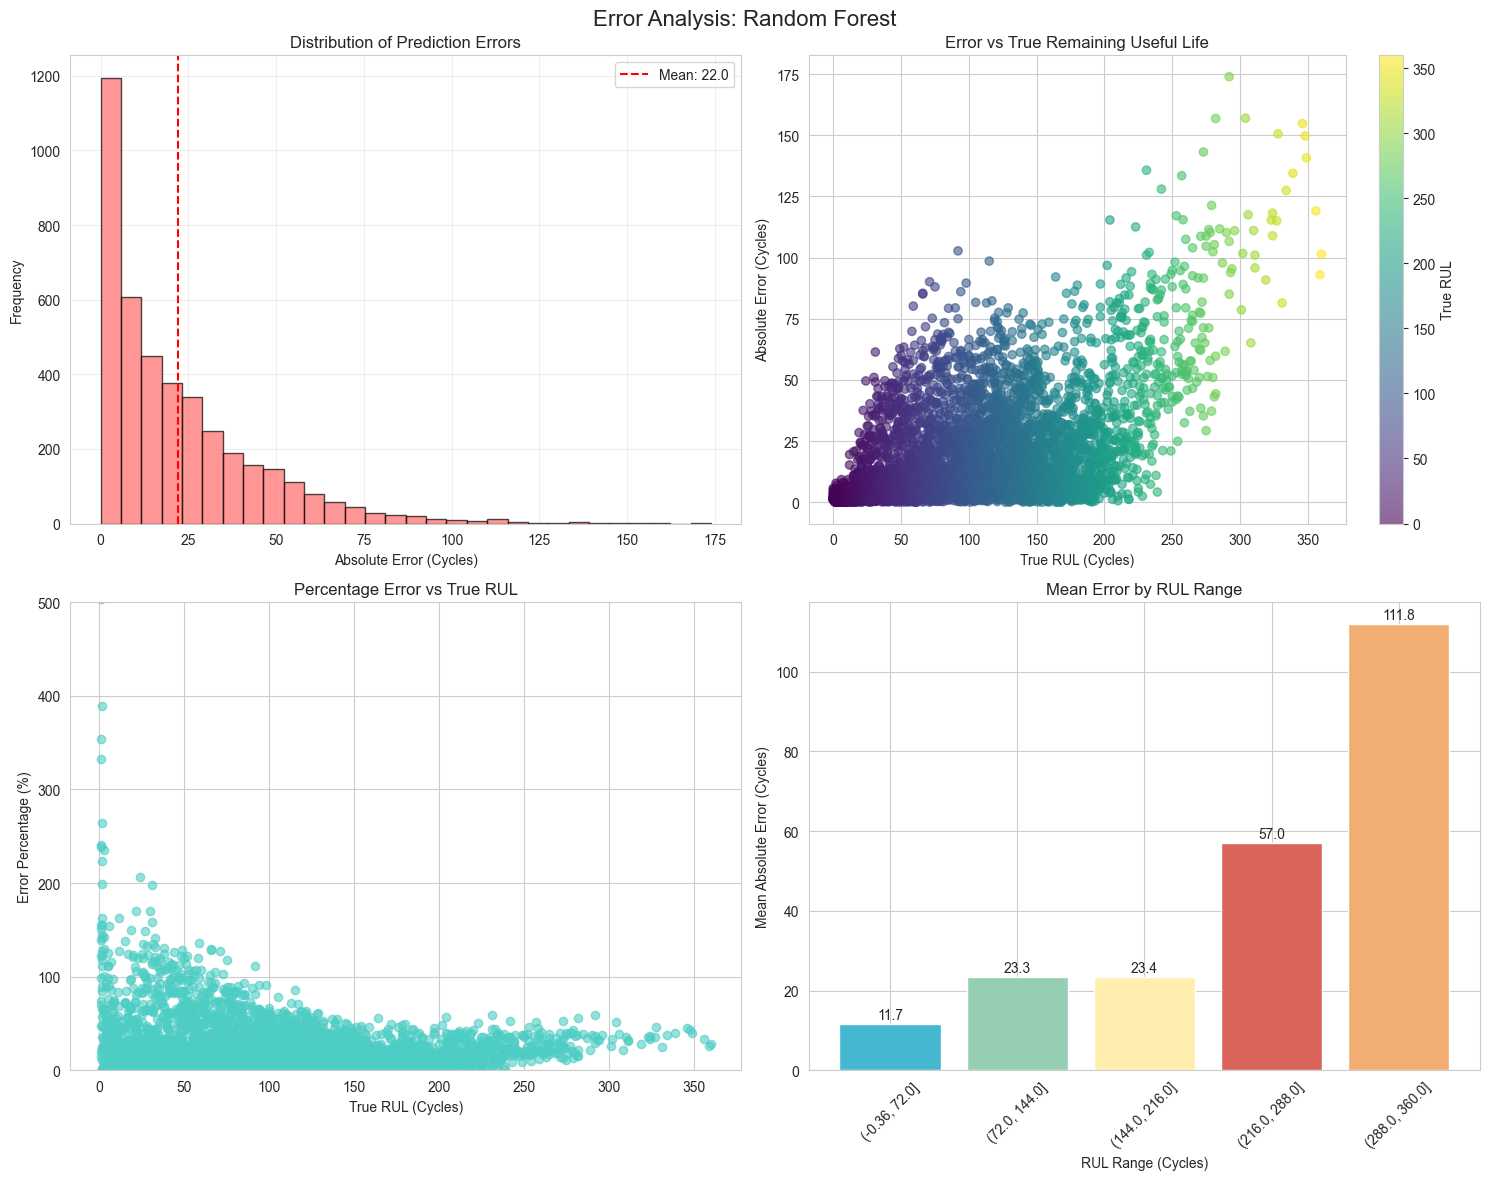


📈 Error Analysis by RUL Segments:
   Very Low RUL (0-20 cycles): 375 samples
     Mean Error: 3.3 cycles, Median Error: 2.2 cycles
   Low RUL (21-50 cycles): 609 samples
     Mean Error: 11.9 cycles, Median Error: 6.2 cycles
   Medium RUL (51-100 cycles): 967 samples
     Mean Error: 21.0 cycles, Median Error: 14.9 cycles
   High RUL (101+ cycles): 2176 samples
     Mean Error: 28.4 cycles, Median Error: 21.8 cycles

🔴 Top 5 Worst Predictions (Errors > 150.6 cycles):
   True: 292.0, Predicted: 118.1, Error: 173.9 cycles
   True: 304.0, Predicted: 147.1, Error: 156.9 cycles
   True: 282.0, Predicted: 125.2, Error: 156.8 cycles
   True: 346.0, Predicted: 191.2, Error: 154.8 cycles
   True: 328.0, Predicted: 177.4, Error: 150.6 cycles


In [16]:
print("\n2. ERROR ANALYSIS")
print("-" * 40)

# Get predictions from the best model
best_model_name = performance_df.index[0]
best_predictions = model_performance[best_model_name]['Model'].predict(X_val)

# Create detailed error analysis DataFrame
error_analysis = pd.DataFrame({
    'True_RUL': y_val.values,
    'Predicted_RUL': best_predictions,
    'Absolute_Error': np.abs(y_val.values - best_predictions),
    'Error_Percentage': (np.abs(y_val.values - best_predictions) / y_val.values) * 100
})

# Avoid infinite values from division by zero
error_analysis['Error_Percentage'] = error_analysis['Error_Percentage'].replace([np.inf, -np.inf], np.nan)

print(f"📋 Overall Error Statistics for {best_model_name}:")
print(f"   Mean Absolute Error: {error_analysis['Absolute_Error'].mean():.2f} cycles")
print(f"   Median Absolute Error: {error_analysis['Absolute_Error'].median():.2f} cycles")
print(f"   Std Deviation of Error: {error_analysis['Absolute_Error'].std():.2f} cycles")
print(f"   Max Error: {error_analysis['Absolute_Error'].max():.2f} cycles")
print(f"   Mean Error Percentage: {error_analysis['Error_Percentage'].mean():.2f}%")

# Create visual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Error Analysis: {best_model_name}', fontsize=16, y=0.98)

# Plot 1: Error Distribution
axes[0, 0].hist(error_analysis['Absolute_Error'], bins=30, alpha=0.7, 
                color='#FF6B6B', edgecolor='black')
axes[0, 0].axvline(error_analysis['Absolute_Error'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {error_analysis["Absolute_Error"].mean():.1f}')
axes[0, 0].set_xlabel('Absolute Error (Cycles)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Errors')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error vs True RUL
scatter = axes[0, 1].scatter(error_analysis['True_RUL'], error_analysis['Absolute_Error'], 
                            alpha=0.6, c=error_analysis['True_RUL'], cmap='viridis')
axes[0, 1].set_xlabel('True RUL (Cycles)')
axes[0, 1].set_ylabel('Absolute Error (Cycles)')
axes[0, 1].set_title('Error vs True Remaining Useful Life')
plt.colorbar(scatter, ax=axes[0, 1], label='True RUL')

# Plot 3: Percentage Error vs True RUL
axes[1, 0].scatter(error_analysis['True_RUL'], error_analysis['Error_Percentage'], 
                  alpha=0.6, color='#4ECDC4')
axes[1, 0].set_xlabel('True RUL (Cycles)')
axes[1, 0].set_ylabel('Error Percentage (%)')
axes[1, 0].set_title('Percentage Error vs True RUL')
axes[1, 0].set_ylim(0, min(500, error_analysis['Error_Percentage'].max() * 1.1))

# Plot 4: Error by RUL Bins
rul_bins = pd.cut(error_analysis['True_RUL'], bins=5)
error_by_bin = error_analysis.groupby(rul_bins)['Absolute_Error'].mean()

bars = axes[1, 1].bar(range(len(error_by_bin)), error_by_bin.values, 
                     color=['#45B7D1', '#96CEB4', '#FFEEAD', '#D96459', '#F2AE72'])
axes[1, 1].set_xlabel('RUL Range (Cycles)')
axes[1, 1].set_ylabel('Mean Absolute Error (Cycles)')
axes[1, 1].set_title('Mean Error by RUL Range')
axes[1, 1].set_xticks(range(len(error_by_bin)))
axes[1, 1].set_xticklabels([str(bin) for bin in error_by_bin.index], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Quantitative analysis by RUL segments
print("\n📈 Error Analysis by RUL Segments:")
rul_segments = {
    'Very Low RUL (0-20 cycles)': (0, 20),
    'Low RUL (21-50 cycles)': (21, 50),
    'Medium RUL (51-100 cycles)': (51, 100),
    'High RUL (101+ cycles)': (101, error_analysis['True_RUL'].max())
}

for segment_name, (low, high) in rul_segments.items():
    segment_data = error_analysis[(error_analysis['True_RUL'] >= low) & 
                                (error_analysis['True_RUL'] <= high)]
    if len(segment_data) > 0:
        mean_error = segment_data['Absolute_Error'].mean()
        median_error = segment_data['Absolute_Error'].median()
        print(f"   {segment_name}: {len(segment_data)} samples")
        print(f"     Mean Error: {mean_error:.1f} cycles, Median Error: {median_error:.1f} cycles")

# Identify worst predictions
worst_predictions = error_analysis.nlargest(5, 'Absolute_Error')
print(f"\n🔴 Top 5 Worst Predictions (Errors > {worst_predictions['Absolute_Error'].min():.1f} cycles):")
for idx, row in worst_predictions.iterrows():
    print(f"   True: {row['True_RUL']:.1f}, Predicted: {row['Predicted_RUL']:.1f}, "
          f"Error: {row['Absolute_Error']:.1f} cycles")